### Observations
- First peak always positive, small amplitude, often has an early shoulder and more noise
- Second peak negative, medium amlitude -> third peak positive, largest amplitude
- Third peak (second positive) used for pressure calibration
- Envelope: 1-2 cycle rise -> exp. decay + low frequency oscillation (f = 18-22Hz)

In [1]:
import audacity as au
import numpy as np
import scipy.io.wavfile as wf
import scipy.signal as sig
import matplotlib.pyplot as pl
%matplotlib notebook

In [2]:
def keyclose_analysis(aupfile):
    auf = au.Aup(aupfile)
    w = [ auf.get_channel_data(chno) for chno in range(auf.nchannels) ]
    sr = auf.rate
    w1=w[0]
    w2=w[1]
    ann = auf.get_annotation_data()
    clips = [ w1[int(ann[i]['start']*sr):int(ann[i]['end']*sr)] for i in range(len(ann)) ]
    key = [ w2[int(ann[i]['start']*sr):int(ann[i]['end']*sr)] for i in range(len(ann)) ]
    return clips, key, sr

In [3]:
def pressure_calib(aupfile):
    auf = au.Aup(aupfile)
    w = [ auf.get_channel_data(chno) for chno in range(auf.nchannels) ]
    sr = auf.rate
    w1=w[0]
    ann = auf.get_annotation_data()
    clips = [ w1[int(ann[i]['start']*sr):int(ann[i]['end']*sr)] for i in range(len(ann))]
    peaks = [ np.amax(clips[j]) for j in range(len(ann))]
    Pa = [ float(ann[k]['label']) for k in range(len(ann))]
    return Pa, peaks

In [31]:
sr = keyclose_analysis('key_only_recordings/calibration/key_only1.aup')[2]
audio = []
keysig = []
for n in range(1, 11):
    rec = 'key_only_recordings/calibration/key_only%d.aup' %n
    audio.append(keyclose_analysis(rec)[0])
    keysig.append(keyclose_analysis(rec)[1])

In [5]:
xP = []
yP = []
for n in range(1, 11):
    rec = 'key_only_recordings/calibration/key_only%d.aup' %n
    xP.extend(pressure_calib(rec)[0])
    yP.extend(pressure_calib(rec)[1])

In [6]:
(ar,br) = np.polyfit(xP,yP,1)
yr = np.polyval([ar,br],xP)
err = np.sqrt(sum((yr-yP)**2)/len(yP))

<IPython.core.display.Javascript object>


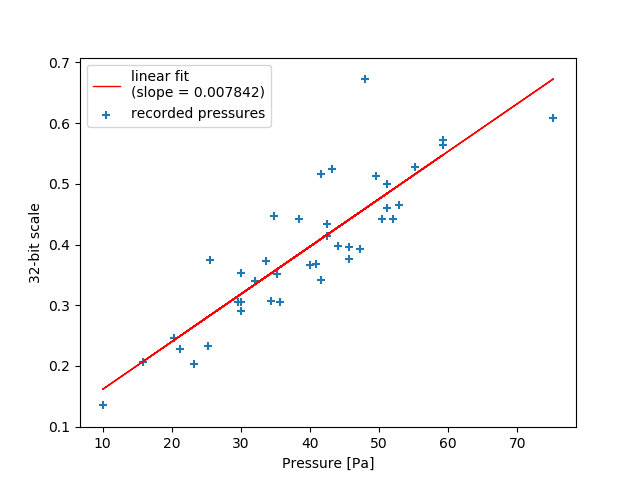

Text(0,0.5,'32-bit scale')

In [7]:
pl.figure('Key closing - pressure calibration')
pl.scatter(xP, yP, marker='+')
pl.plot(xP, yr, 'r-', linewidth='1')
pl.legend(('linear fit \n(slope = %f)' %ar, 'recorded pressures'))
pl.xlabel('Pressure [Pa]')
pl.ylabel('32-bit scale')

<IPython.core.display.Javascript object>


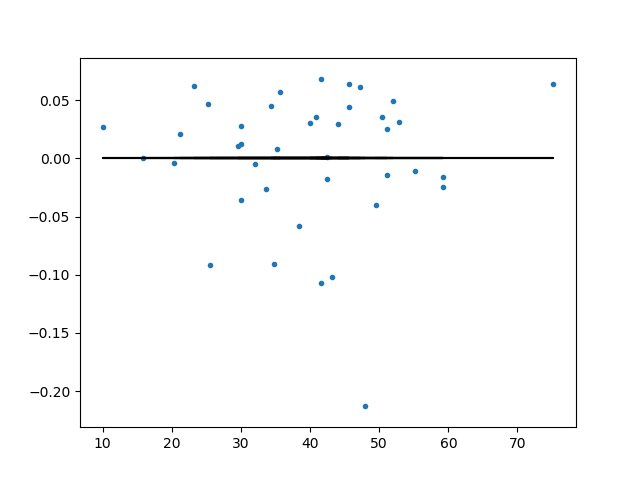

In [8]:
pl.figure()
pl.scatter(xP, yr-yP, marker='.')
pl.plot(xP, np.zeros(len(xP)), 'k-')

<IPython.core.display.Javascript object>


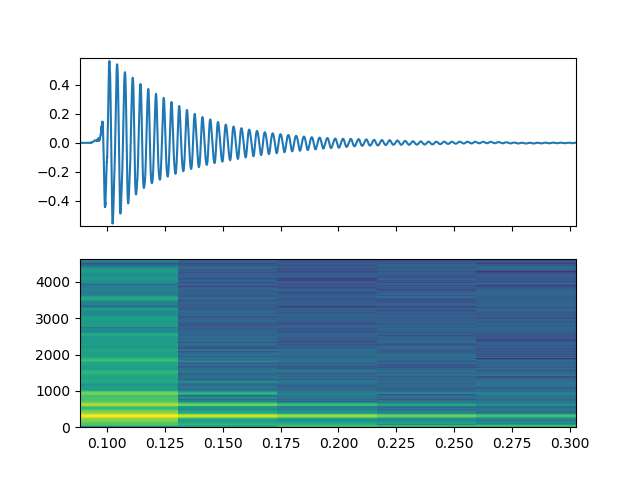

In [8]:
fig,ax = pl.subplots(2, sharex=True)
testaudio = audio[0][2]

ax[0].plot(np.arange(len(testaudio))/sr, testaudio)
ax[1].specgram(testaudio, 2024, Fs=sr);

In [10]:
def RMSWind(x, sr=1, nwind=1024, nhop=512, windfunc=np.blackman):
    '''
    Calculates the RMS amplitude amplitude of x, in frames of
    length nwind, and in steps of nhop. windfunc is used as
    windowing function.
    nwind should be at least 3 periods if the signal is periodic.
    '''

    nsam = len(x)
    ist = 0
    iend = ist+nwind

    t = []
    ret = []

    wind = windfunc(nwind)
    wsum2 = np.sum(wind**2)

    while (iend < nsam):
        thisx = x[ist:iend]
        xw = thisx*wind

        ret.append(np.sum(xw*xw/wsum2))
        t.append(float(ist+iend)/2.0/float(sr))

        ist = ist+nhop
        iend = ist+nwind

    return np.sqrt(np.array(ret)), np.array(t)

In [11]:
b, a = sig.butter(4, 250/sr, 'high')
testsig = sig.filtfilt(b,a,testaudio, padtype='constant')

rms, t=RMSWind(testsig,sr=sr,nwind=360,nhop=80)

<IPython.core.display.Javascript object>


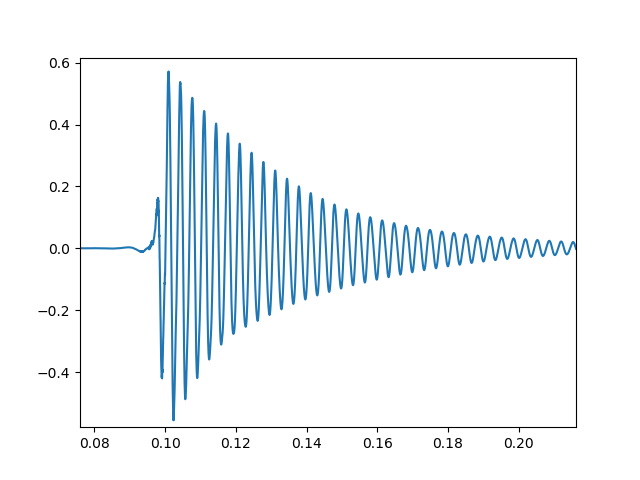

In [32]:
testamp = rms*np.sqrt(2)

pl.figure()
pl.plot(np.arange(len(testsig))/sr, testsig)
# pl.semilogy(np.arange(len(testsig))/sr, testsig)
# pl.plot(t, testamp)
maxargs = sig.argrelmax(testsig, order=5)[0]
maxvals = [ testsig[arg] for arg in maxargs ]
# pl.plot(maxargs/sr, maxvals)

In [13]:
# expfit = np.polyfit(maxargs, np.log(maxvals), 1, w=np.sqrt(maxvals))
# pl.plot(expfit, 'r-')
# would need to resrict region for fitting, slice maxargs

<IPython.core.display.Javascript object>


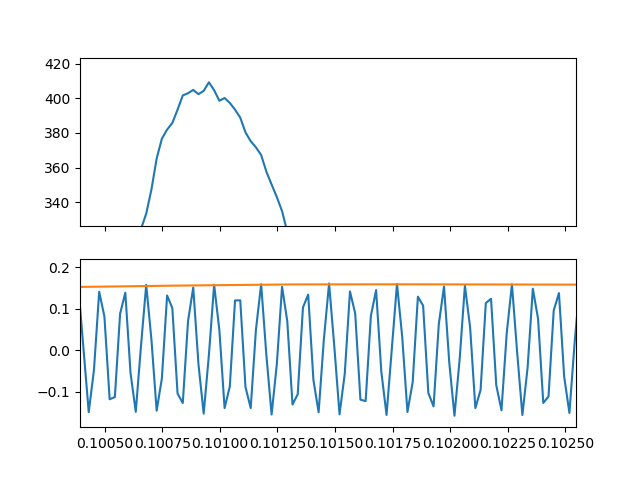

In [26]:
q, p = sig.butter(4, 1000/sr, 'high')
testkey = sig.filtfilt(q,p,keysig[0][2], padtype='constant')

keyRMS, t_k=RMSWind(testkey,sr=sr,nwind=16,nhop=20)
testamp_k = keyRMS*np.sqrt(2)

fig,ax=pl.subplots(2,sharex=True)
ax[0].plot(np.arange(len(testsig))/sr, testsig/0.0013967527449131013)
ax[1].plot(np.arange(len(testkey))/sr, testkey)
ax[1].plot(t_k, testamp_k)

#pl.semilogy(np.arange(len(keysig))/sr, keysig)
# pl.plot(t, rms*np.sqrt(2))
# maxargs = sig.argrelmax(testsig, order=10)[0]
# maxvals = [ testsig[arg] for arg in maxargs ]
# ax[0].plot(maxargs/sr, maxvals)

In [15]:
zoom_x = testamp_k[int(0.093*2206):int(0.11*2206)]
zoom_t = t_k[int(0.093*2206):int(0.11*2206)]

<IPython.core.display.Javascript object>


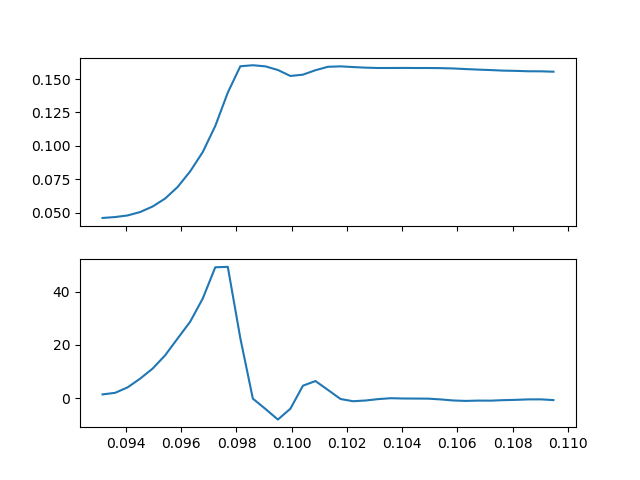

In [16]:
fig, ax=pl.subplots(2, sharex=True)
ax[0].plot(zoom_t, zoom_x)
zoom_v = np.gradient(zoom_x)/np.gradient(zoom_t)
ax[1].plot(zoom_t, zoom_v)

In [18]:
xdiff = np.amax(zoom_x)-np.amin(zoom_x)

In [24]:
d_convert = 0.00264/xdiff
d_convert

0.023091481474031384

<IPython.core.display.Javascript object>


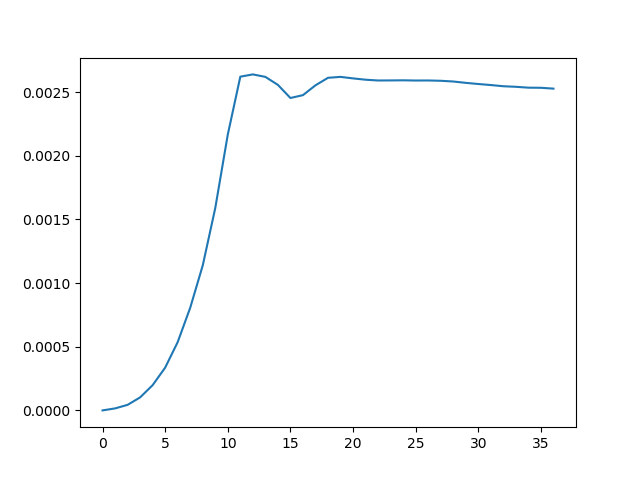

In [20]:
zoom_d = zoom_x*d_convert-np.amin(zoom_x)*d_convert
pl.figure()
pl.plot(zoom_d)

<IPython.core.display.Javascript object>


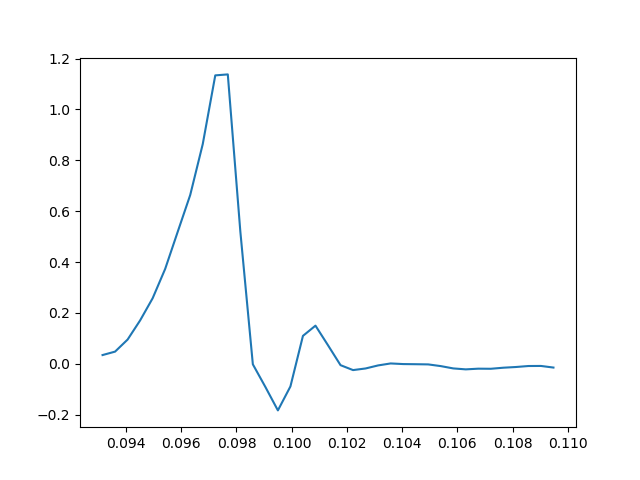

In [21]:
zoom_vSI = np.gradient(zoom_d)/np.gradient(zoom_t)
pl.figure()
pl.plot(zoom_t, zoom_vSI)

In [22]:
max_p = np.amax(testsig)/0.0013967527449131013
max_p

409.22337363838471

<IPython.core.display.Javascript object>


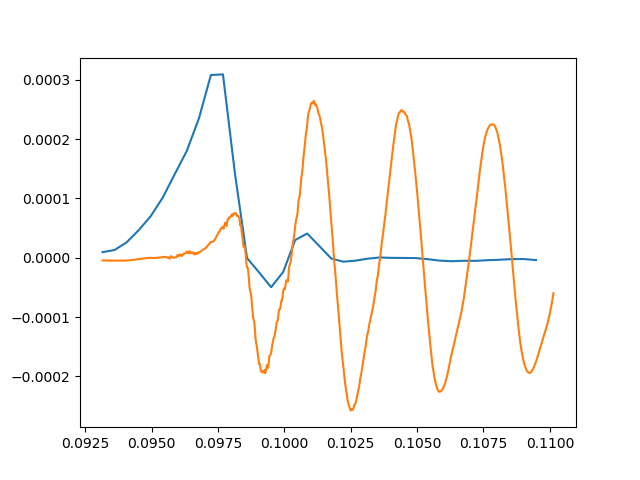

186

In [23]:
Z=1546352.9
S=0.00027172

keyflowsig = zoom_vSI*S
# pflowsig = (rms*np.sqrt(2))[int(0.093*len(t)/len(test_t)):int(0.099*len(t)/len(test_t))]/Z
# pflowsig = maxvals[int(0.093*len(maxvals)/(len(testaudio)/sr)):int(0.099*len(maxvals)/(len(testaudio)/sr))]
pflowsig = (testsig[int(0.093*sr):int(0.11*sr)]/0.0013967527449131013)/Z

# fig, ax=pl.subplots(2, sharex=True)
pl.figure()
pl.plot(zoom_t, keyflowsig)
pl.plot(np.arange(len(pflowsig))/sr+zoom_t[0], pflowsig)
# pl.yscale('log')
len(testamp)

In [77]:
int(0.093*len(maxvals)/(len(testaudio)/sr))

116

In [78]:
len(maxvals)/(len(testaudio)/sr)

1256.0954704292215

In [25]:
sig.filtfilt?

In [ ]:
clips_short = []
for clip in audio:
    

In [33]:
1020/0.145

7034.48275862069